## Imports

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import torch
from transformers import MarianMTModel, MarianTokenizer
import torch
from tqdm import tqdm
import gc
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from transformers import BertTokenizer
from collections import Counter
import torch as pt
import matplotlib.pyplot as plt

## Read Data and Perform Label Mapping

In [2]:
df = pd.read_csv("articles_cleaned.csv")
df.head()

,source,title,category,content,score,content_length
0,Yahoo Business,Wall St. Pullback Reflects Tech Blowout (Reuters),business,"Reuters - Wall Street's long-playing drama, ""W...",5.0,200
1,Yahoo Business,Wall St. Bears Claw Back Into the Black (Reuters),business,"Reuters - Short-sellers, Wall Street's dwindli...",5.0,94
2,Yahoo Business,Carlyle Looks Toward Commercial Aerospace (Reu...,business,Reuters - Private investment firm Carlyle Grou...,5.0,214
3,Yahoo Business,Oil and Economy Cloud Stocks' Outlook (Reuters),business,Reuters - Soaring crude prices plus worries ab...,5.0,184
4,Yahoo Business,Iraq Halts Oil Exports from Main Southern Pipe...,business,Reuters - Authorities have halted oil export f...,5.0,195


In [3]:
with open("label_mappings.json", "r") as f:
    mappings = json.load(f)
    label_to_id = mappings["label_to_id"]

df['label_id'] = df['category'].map(label_to_id)
df.head()

,source,title,category,content,score,content_length,label_id
0,Yahoo Business,Wall St. Pullback Reflects Tech Blowout (Reuters),business,"Reuters - Wall Street's long-playing drama, ""W...",5.0,200,3
1,Yahoo Business,Wall St. Bears Claw Back Into the Black (Reuters),business,"Reuters - Short-sellers, Wall Street's dwindli...",5.0,94,3
2,Yahoo Business,Carlyle Looks Toward Commercial Aerospace (Reu...,business,Reuters - Private investment firm Carlyle Grou...,5.0,214,3
3,Yahoo Business,Oil and Economy Cloud Stocks' Outlook (Reuters),business,Reuters - Soaring crude prices plus worries ab...,5.0,184,3
4,Yahoo Business,Iraq Halts Oil Exports from Main Southern Pipe...,business,Reuters - Authorities have halted oil export f...,5.0,195,3


In [4]:
print(len(df['category'].value_counts(dropna=False)))
print(df['category'].value_counts(dropna=False).head(6))

6
category
world            611528
sci/tech         157826
entertainment    143670
business         132598
sports           116488
health            42387
Name: count, dtype: int64


## Back-Translation

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [12]:
en_to_fr_model_name = "Helsinki-NLP/opus-mt-en-fr"
fr_to_en_model_name = "Helsinki-NLP/opus-mt-fr-en"

en_fr_tokenizer = MarianTokenizer.from_pretrained(en_to_fr_model_name)
en_fr_model = MarianMTModel.from_pretrained(en_to_fr_model_name).to(device)

fr_en_tokenizer = MarianTokenizer.from_pretrained(fr_to_en_model_name)
fr_en_model = MarianMTModel.from_pretrained(fr_to_en_model_name).to(device)

In [13]:
def translate(texts, tokenizer, model, device, max_length=128):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=max_length,
            num_beams=4,
            do_sample=False
        )
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)

def back_translate(texts, batch_size=8):
    back_translated_texts = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Back-translating"):
        torch.cuda.empty_cache()
        gc.collect()
        batch = texts[i:i+batch_size]
        try:
            fr_texts = translate(batch, en_fr_tokenizer, en_fr_model, device)
            en_texts = translate(fr_texts, fr_en_tokenizer, fr_en_model, device)
            back_translated_texts.extend(en_texts)
        except RuntimeError as e:
            print(f"CUDA error at batch {i}, reducing batch size or sequence length might help: {e}")
            back_translated_texts.extend(batch)  

    return back_translated_texts

In [9]:
health_df = df[df["category"] == "health"]
health_texts = health_df["content"].tolist()

In [15]:
augmented_health_texts = back_translate(health_texts, batch_size=8)

augmented_df = pd.DataFrame({
    'source': 'back_translated',
    'title': '', 
    'category': 'health',
    'content': augmented_health_texts,
    'score': 5.0,  
    'content_length': [len(text) for text in augmented_health_texts],
    'label_id': 5
})

df_augmented = pd.concat([df, augmented_df], ignore_index=True)

Back-translating: 100%|████████████████████████| 5299/5299 [59:39<00:00,  1.48it/s]


In [18]:
len(df_augmented[df_augmented['category'] == 'health'])

84774

In [19]:
df_augmented.to_csv("augmented_data.csv", index=False)

In [23]:
dup_counts = (
    df_augmented.groupby("category")["content"]
    .apply(lambda x: x.duplicated().sum())
    .reset_index(name="num_duplicates")
)

print(dup_counts)

        category  num_duplicates
0       business           19779
1  entertainment           28604
2         health           20359
3       sci/tech           33849
4         sports           11586
5          world          197693


In [26]:
df_cleaned = df_augmented.drop_duplicates(subset=["content", "label_id"])

In [27]:
df_cleaned.to_csv("augmented_data_cleaned.csv", index=False)

In [28]:
dup_counts = (
    df_cleaned.groupby("category")["content"]
    .apply(lambda x: x.duplicated().sum())
    .reset_index(name="num_duplicates")
)

print(dup_counts)

        category  num_duplicates
0       business               0
1  entertainment               0
2         health               0
3       sci/tech               0
4         sports               0
5          world               0


## Use the same architecture to observe the differences

In [2]:
class TransformerBlock(nn.Module):
    def __init__(self, embeddings_dimension, heads, ff_hidden_dim, dropout):
        super().__init__()
        self.attention = nn.MultiheadAttention(embeddings_dimension, heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(embeddings_dimension)
        self.ff = nn.Sequential(
            nn.Linear(embeddings_dimension, ff_hidden_dim),
            nn.ReLU(),
            nn.Linear(ff_hidden_dim, embeddings_dimension)
        )
        self.norm2 = nn.LayerNorm(embeddings_dimension)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attn_mask):
        key_padding_mask = (attn_mask == 0) 
        attn_output, _ = self.attention(x, x, x, key_padding_mask=key_padding_mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [3]:
class NewsClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes=6, embed_dim=128, num_heads=4,
                 num_layers=4, ff_hidden_dim=256, max_len=128, dropout=0.1):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, embed_dim)
        self.pos_emb = nn.Embedding(max_len, embed_dim)

        self.layers = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_hidden_dim, dropout)
            for _ in range(num_layers)
        ])

        self.cls_head = nn.Linear(embed_dim, num_classes)  

    def forward(self, input_ids, attn_mask):
        batch_size, seq_len = input_ids.size()
        positions = pt.arange(seq_len, device=input_ids.device).unsqueeze(0).expand(batch_size, seq_len)

        x = self.token_emb(input_ids) + self.pos_emb(positions)

        for layer in self.layers:
            x = layer(x, attn_mask)

        cls_token = x[:, 0]  
        return self.cls_head(cls_token)  

## Dataset and Dataloader

In [4]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=pt.long)
        }

## Train-Test-Split

In [5]:
df_cleaned = pd.read_csv("augmented_data_cleaned.csv", dtype={"title": str}, low_memory=False)

texts = df_cleaned['content'].values
labels = df_cleaned['label_id'].values

train_texts, val_test_texts, train_labels, val_test_labels = train_test_split(texts, labels, test_size=0.4, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(val_test_texts, val_test_labels, test_size=0.5, random_state=42)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = NewsDataset(train_texts, train_labels, tokenizer)
val_dataset = NewsDataset(val_texts, val_labels, tokenizer)
test_dataset = NewsDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
print(df_cleaned['category'].value_counts())

category
world            413835
sci/tech         123977
entertainment    115066
business         112819
sports           104902
health            64415
Name: count, dtype: int64


## Compute weights for Cross-Entropy

In [8]:
with open("label_mappings.json", "r") as f:
    mappings = json.load(f)
    label_to_id = mappings["label_to_id"]

label_counts = Counter(df_cleaned['category'].values)

count_list = [label_counts[label] for label in label_to_id]
print(f"The total number of samples for each one of the categories: {count_list}")

class_counts = torch.tensor(count_list, dtype=torch.float)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() 
class_weights = class_weights.to(device)
print(f"Computed weights for the loss function according to the specified categories:{class_weights}")

The total number of samples for each one of the categories: [413835, 123977, 115066, 112819, 104902, 64415]
Computed weights for the loss function according to the specified categories:tensor([0.0455, 0.1519, 0.1637, 0.1669, 0.1795, 0.2924], device='cuda:0')


## Training and Evaluation

In [9]:
def train_epoch(model, data_loader, optimizer, device, class_weights):
    model.train()
    total_loss = 0
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    for batch in tqdm(data_loader):

        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss = total_loss + loss.item()


    return total_loss / len(data_loader)

def evaluate(model, data_loader, device, class_weights):
    model.eval()
    predictions = []
    actual_labels = []
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    total_loss = 0

    with pt.no_grad():
        for batch in tqdm(data_loader):

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)

            total_loss = total_loss + loss.item()

            _, predicted = pt.max(logits, 1)
            predictions.extend(predicted.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())

    # print(predictions)
    accuracy = accuracy_score(actual_labels, predictions)

    return total_loss / len(data_loader), accuracy

In [11]:
model = NewsClassifier(vocab_size=tokenizer.vocab_size, num_classes=6).to(device)
path = 'bert_news_model_augmented.pt'

optimizer = AdamW(model.parameters(), lr=5e-4)

num_epochs = 10
best_accuracy = 0

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch number {epoch + 1}/{num_epochs}")

    train_loss = train_epoch(model, train_loader, optimizer, device, class_weights)
    print(f"Train loss: {train_loss:.4f}")

    val_loss, accuracy = evaluate(model, val_loader, device, class_weights)
    print(f"Validation loss: {val_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(accuracy)
    
    if best_accuracy < accuracy:
        best_accuracy = accuracy
        pt.save(model.state_dict(), path)

    print()

np.save("train_losses_aug.npy", np.array(train_losses))
np.save("val_losses_aug.npy", np.array(val_losses))
np.save("val_accuracies_aug.npy", np.array(val_accuracies))

Epoch number 1/10


100%|████████████████████████████████████████████| 70126/70126 [09:39<00:00, 121.01it/s]


Train loss: 0.8159


100%|████████████████████████████████████████████| 23376/23376 [01:27<00:00, 266.13it/s]


Validation loss: 0.6633
Accuracy: 0.7293

Epoch number 2/10


100%|████████████████████████████████████████████| 70126/70126 [09:37<00:00, 121.53it/s]


Train loss: 0.6323


100%|████████████████████████████████████████████| 23376/23376 [01:27<00:00, 268.68it/s]


Validation loss: 0.6281
Accuracy: 0.7395

Epoch number 3/10


100%|████████████████████████████████████████████| 70126/70126 [09:38<00:00, 121.32it/s]


Train loss: 0.5932


100%|████████████████████████████████████████████| 23376/23376 [01:27<00:00, 267.35it/s]


Validation loss: 0.6392
Accuracy: 0.7203

Epoch number 4/10


100%|████████████████████████████████████████████| 70126/70126 [09:36<00:00, 121.71it/s]


Train loss: 0.5728


100%|████████████████████████████████████████████| 23376/23376 [01:27<00:00, 266.62it/s]


Validation loss: 0.6068
Accuracy: 0.7394

Epoch number 5/10


100%|████████████████████████████████████████████| 70126/70126 [09:38<00:00, 121.21it/s]


Train loss: 0.5613


100%|████████████████████████████████████████████| 23376/23376 [01:27<00:00, 265.68it/s]


Validation loss: 0.6217
Accuracy: 0.7147

Epoch number 6/10


 48%|███████████████████▊                     | 33906/70126 [6:17:54<6:43:42,  1.50it/s]


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


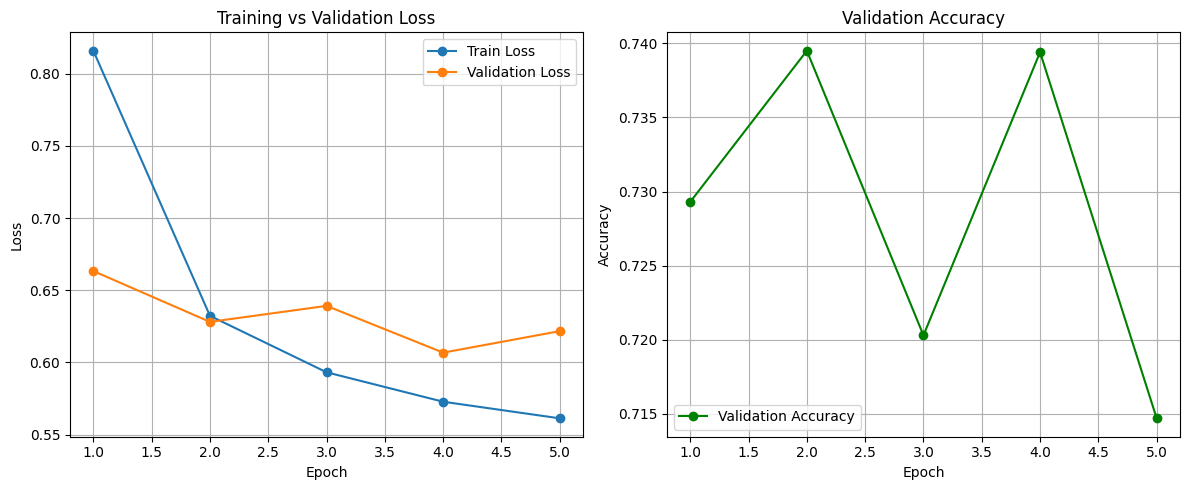

In [12]:
train_losses = [0.8159, 0.6323, 0.5932, 0.5728, 0.5613]
val_losses = [0.6633, 0.6281, 0.6392, 0.6068, 0.6217]
val_accuracies = [0.7293, 0.7395, 0.7203, 0.7394, 0.7147]
epochs = [1, 2, 3, 4, 5]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('loss_acc_augmented.jpg')
plt.show()

## Final Evaluation

In [13]:
def inference(model, tokenizer, device, text):
    model.eval()
    with pt.no_grad():
        encoding = tokenizer(
            text,
            add_special_tokens=True,
            max_length=128,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        logits = model(input_ids=input_ids, attn_mask=attention_mask)
        _, predicted = pt.max(logits, dim=1)
 
        predicted_label = predicted.item()
        print(f"Predicted Category: {label_map[predicted_label]}")
        return predicted_label

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = NewsClassifier(vocab_size=tokenizer.vocab_size, num_classes=6).to(device)
model.load_state_dict(pt.load('bert_news_model_augmented.pt', map_location=device))
model.to(device)
model.eval()

with open("label_mappings.json", "r") as f:
    mappings = json.load(f)

label_to_id = mappings["label_to_id"]
label_map = {int(k): v for k, v in mappings["label_map"].items()} 
print("Label Map:", label_map)

text = "The company’s quarterly profits exceeded analyst expectations and shares rose 5%."
_ = inference(model, tokenizer, device, text)

Label Map: {0: 'world', 1: 'sci/tech', 2: 'entertainment', 3: 'business', 4: 'sports', 5: 'health'}
Predicted Category: business


In [15]:
def evaluate_model(model, test_loader, device, label_map):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    target_names = [label_map[i] for i in range(len(label_map))]
    
    report = classification_report(all_labels, all_preds, target_names=target_names)
    print("Classification Report:\n", report)

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", cm)

    return report, cm

In [16]:
report, cm = evaluate_model(model, test_loader, device, label_map)

Classification Report:
                precision    recall  f1-score   support

        world       0.92      0.69      0.79     82697
     sci/tech       0.66      0.86      0.75     24951
entertainment       0.57      0.55      0.56     23112
     business       0.71      0.69      0.70     22481
       sports       0.76      0.96      0.85     20893
       health       0.56      0.93      0.70     12869

     accuracy                           0.74    187003
    macro avg       0.69      0.78      0.72    187003
 weighted avg       0.77      0.74      0.74    187003

Confusion Matrix:
 [[56885  4839  7871  4037  3590  5475]
 [  606 21410   800   864   193  1078]
 [ 3299  1924 12665  1396  2281  1547]
 [  952  3858   606 15612   237  1216]
 [  169   165   246    71 20086   156]
 [  168   241   218   118    95 12029]]


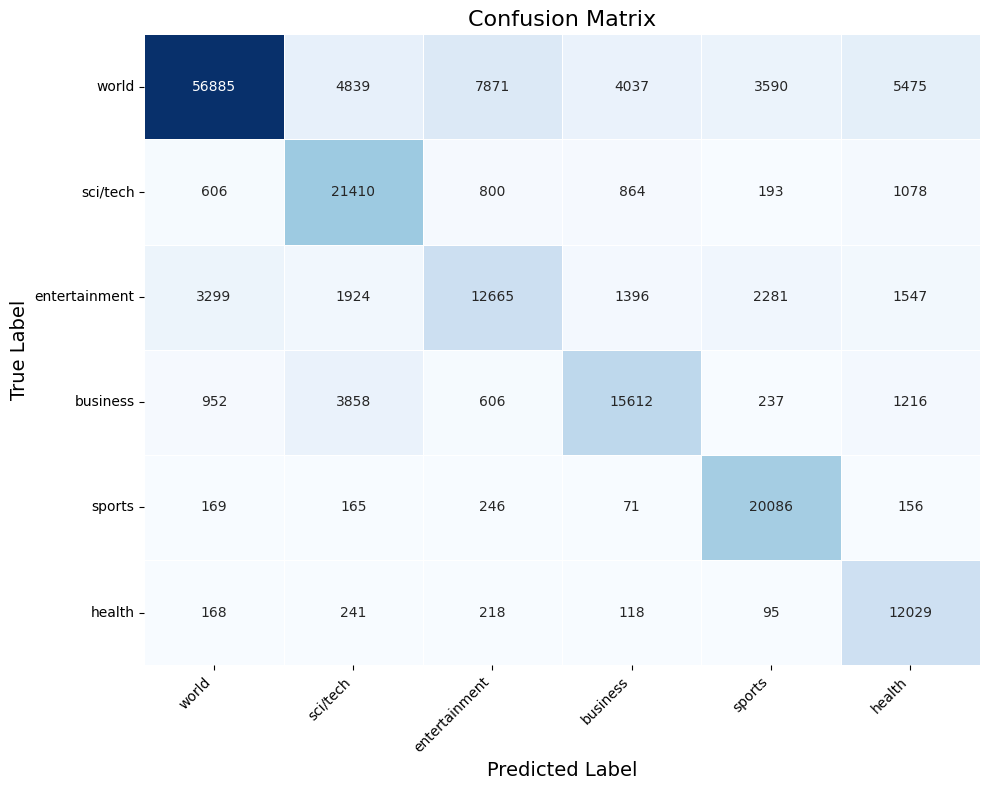

In [23]:
confusion_matrix_data = [[56885, 4839, 7871, 4037, 3590, 5475],
                         [606, 21410, 800, 864, 193, 1078],
                         [3299, 1924, 12665, 1396, 2281, 1547],
                         [952, 3858, 606, 15612, 237, 1216],
                         [169, 165, 246, 71, 20086, 156],
                         [168, 241, 218, 118, 95, 12029]]
cm = np.array(confusion_matrix_data)

label_map = {0: 'world', 1: 'sci/tech', 2: 'entertainment', 3: 'business', 4: 'sports', 5: 'health'}

class_names = [label_map[i] for i in sorted(label_map.keys())]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            linewidths=.5, cbar=False)

plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('cm_augmented.pdf')
plt.show()